# Exploratory Model Analysis: A Demo

When studying a dataset we use an [exploratory analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis) to get an initial impression of the data. We can use a similar approach when studying a model. The [grama](https://joss.theoj.org/papers/10.21105/joss.02462) package is designed to support the analysis of models, including tools for *exploratory model analysis* (EMA). What follows is a short demonstration of EMA using grama.


## Setup

The grama package is a toolkit for analyzing models; you can install it from PyPI with the command line command `pip install py-grama`. Let's load grama to get started.


In [1]:
import grama as gr
DF = gr.Intention()


Grama comes with a variety of built-in models. For a simple example, let's look at a model for the buckling behavior of a [flat plate](https://en.wikipedia.org/wiki/Buckling#Plate_buckling).


In [2]:
from grama.models import make_plate_buckle
md_plate = make_plate_buckle()


## Top-level summary

When exploring a dataset one of the most important first-steps is to inspect top-level summaries, such as the [five-number summary](https://en.wikipedia.org/wiki/Five-number_summary). In EMA there is an analogue in the top-level summary, including the input and output details.


In [3]:
## Return a top-level summary of the model
md_plate


model: Plate Buckling

  inputs:
    var_det:
      w: [6, 18]
      L: [0.00064, 0.00256]
      h: [6, 18]
      t: [0.03, 0.12]

    var_rand:
      E: (+0) norm, {'loc': 10344.736842105263, 'scale': 258.7392188662194}
      mu: (+0) beta, {'a': 1.0039090847355956, 'b': 0.8622625745559566, 'loc': 0.30940527668994305, 'scale': 0.021594723310056966}

    copula:
      Gaussian copula with correlations:
  var1 var2      corr
0   mu    E  0.371244

  functions:
      limit state: ['t', 'h', 'w', 'E', 'mu', 'L'] -> ['g_buckle']

Some key observations from this summary:

- `md_plate` has four deterministic variables: `t, L, w, h`
- the model has two random variables `E, mu`
  - `E` is normally distributed
  - `mu` is distributed as a beta distribution
  - `E` and `mu` have a positive correlation
- the model maps all of its inputs to a single output `g_buckle`
  - this is a limit state; a function where $g > 0$ corresponds to safe operation

## Model Context
  
While summaries are useful for understanding a model, they are not sufficient. One of the additional pieces of information we need to interpret a model is its *context*, including what its inputs and outputs represent. This gives us the knowledge we need to understand the *consequences* of the observations we make. Context is specific to a model, and often not purely mathematical.
  
There is a lot of context we could discuss with the buckling plate model, but this is the most important fact: **Larger values of `g_buckle` indicate a safer plate, while smaller values of `g_buckle` are more dangerous. A value of `g_buckle == 0` is barely unsafe.**
  

## Visual Summaries

For something like a buckling plate, we could inspect the governing equation in order to learn about the model's behavior. An alternative would be to use an EMA approach using visuals.


### Input Effects: Sinew Plots

First, let's use a [sinew plot](https://py-grama.readthedocs.io/en/latest/source/grama.html?highlight=sinew#grama.eval_random.eval_sinews) to study how the inputs affect the output. Note that since `md_plate` contains a great deal of information, we can generate a dataset and visualize the results in just a few lines of code.


Calling plot_sinew_outputs....


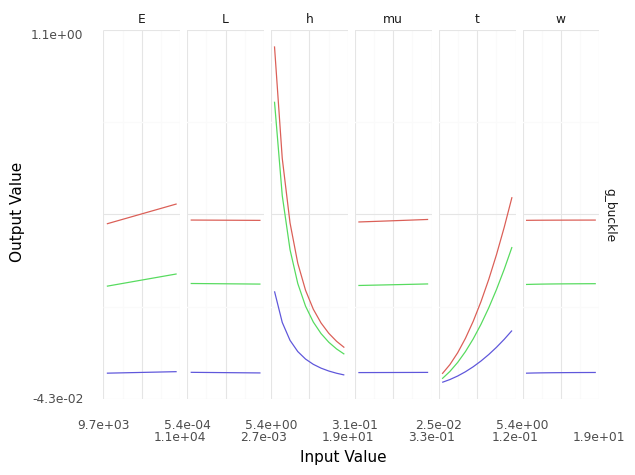

<ggplot: (8780269552113)>

In [4]:
(
    md_plate
    # Evaluate the model
    >> gr.ev_sinews(df_det="swp")
    # Visualize
    >> gr.pt_auto()
)

Every panel above shows a sweep in values for a single input, with all other inputs held to a fixed value. Thus, the collection of curves shows how each input can affect the output, and how those effects compare across the model inputs. For the buckling plate model, we can see:

- the inputs `E, L, mu, w` have relatively little effect
- increasing `h` decreases `g_buckle`
  - This is the height of the plate; a taller plate is more unsafe.
- increasing `t` increases `g_buckle`
  - This is the thickness of the plate; a thicker plate is safer.


We can better understand how a sinew plot is generated by visualizing the input values (ignoring the outputs).


Design runtime estimates unavailable; model has no timing data.
Calling plot_sinew_inputs....


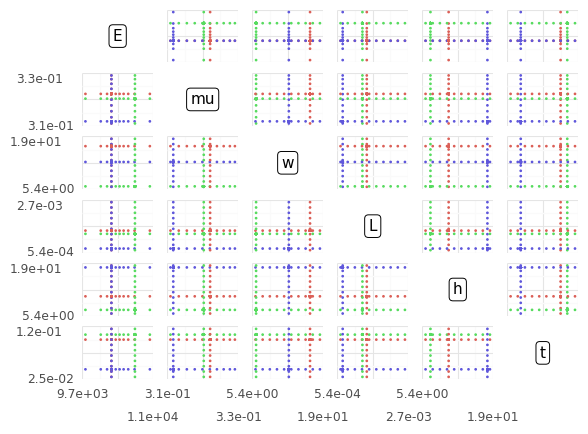

In [5]:
(
    md_plate
    # The `skip` keyword allows us to skip evaluating the model outputs
    >> gr.ev_sinews(df_det="swp", skip=True)
    >> gr.pt_auto()
)

This is a [scatterplot matrix](https://en.wikipedia.org/wiki/Scatter_plot#Scatter_plot_matrices) of all the input values: Notice that we see parallel lines across each panel. These lines are generated by choosing a set of random points within the input space, then sweeping "outward" along each of the input variables.


### Uncertainties: Monte Carlo

From the top-level summary, we saw that the model has two random variables. We can use Monte Carlo to help understand how these uncertainties affect the model results. First, we use a `skip=True` analysis to inspect how the inputs behave.


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
Calling plot_scattermat....


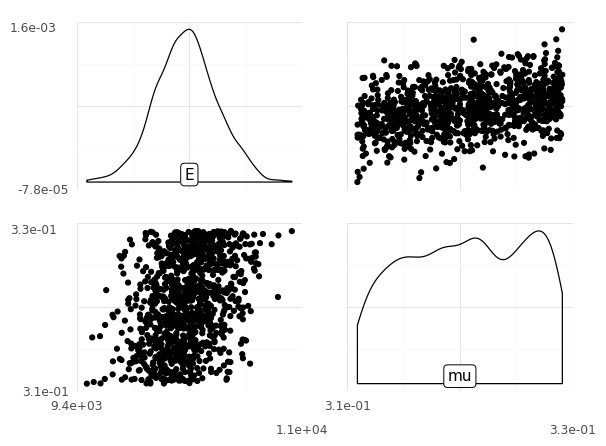

In [6]:
(
    md_plate
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True)
    >> gr.pt_auto()
)

Here we can see that `E` has a normal shape, `mu` has a flatter shape (a beta distribution), and the two variables are positively correlated.


Next, we can remove the `skip` keyword to check how the randomness in the inputs generates randomness in the model outputs. 


eval_monte_carlo() is rounding n...
Calling plot_hists....


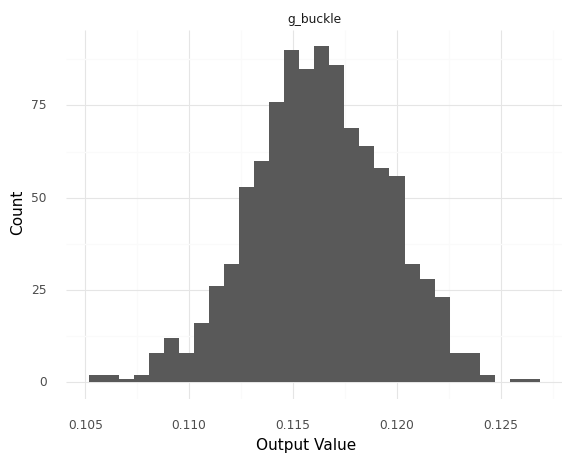

<ggplot: (8780268977312)>

In [7]:
(
    md_plate
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.pt_auto()
)

This shows us that the `g_buckle` output is not certain. However, comparing the width of the distribution (about $\pm 0.01$) to its mean (about $0.115$), we can see that the variability is not large compared to the scale of `g_buckle`.

While grama provides the convenient `gr.pt_auto()` utility, we can construct a more specific plot to encode things like the model context. Remember that the value `g_buckle == 0` is special; we can construct a plot that highlights this special value.


eval_monte_carlo() is rounding n...


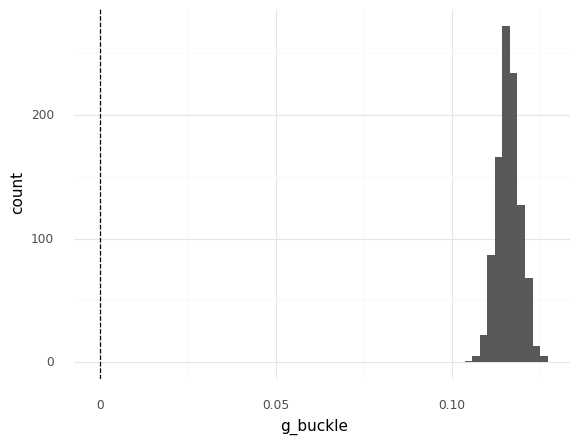

<ggplot: (8780268084923)>

In [8]:
(
    md_plate
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.ggplot(gr.aes("g_buckle"))
    + gr.geom_histogram(bins=60)
    + gr.geom_vline(xintercept=0, linetype="dashed")
    + gr.theme_minimal()
)

This version of the plot shows that the distribution of `g_buckle` is very well separated from the zero threshold: This shows us that the model suggests a very safe plate that is not in danger of buckling.
